<h1 style= font-size:30px><center><br>TEST TECHNIQUE DESCARTES UNDERWRITING </center></h1>
<h3 style= float:right> Parfait FANGUE  </h3>

## 0- Introduction

L'objectif de ce projet est de prédire la variable **TARGET_FLAG** en s'appuyant sur un échantillon de données de **8161 observations** comportant **23 variables explicatives**.
Pour mener à bien ce projet, j'ai adopté une démarche en 8 grandes étapes:
* 1- Chargement et traitement des valeurs manquantes
* 2- Analyse exploratoire
* 3- Preprocessing et Feature engineering
* 4- Machine learning
* 5- Courbe ROC et matrice de confusion de notre meilleur modèle 
* 6- Interprétation du meilleur modèle avec SHAP (SHapley Additive exPlanations)
* 7- Bilan et perspectives
* 8- Prédiction sur le jeu de données Test

Disposant de très peu d'informations *Métiers* et de très peu de temps, je me suis principalement focalisé sur la phase algorithmique.

## Chargement des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, plot_roc_curve, f1_score, roc_curve, auc, make_scorer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle
import shap
shap.initjs()
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

## 1- Chargement des données et traitement des valeurs manquantes

### 1-1 Chargement du jeu de données train

In [2]:
data_train = pd.read_csv('./train_auto.csv', sep=',').drop(columns=['INDEX'])

In [3]:
data_train.shape

(8161, 25)

In [4]:
data_train.head()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


**Commentaire :** Le jeu de données d'entrainements possède **8161 observations** et 25 colonnes parmi lesquelles **23 variables explicatives**, **1 variable cible à savoir TARGET_FLAG** et une autre **variable cible TARGET_AMT**

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  8161 non-null   int64  
 1   TARGET_AMT   8161 non-null   float64
 2   KIDSDRIV     8161 non-null   int64  
 3   AGE          8155 non-null   float64
 4   HOMEKIDS     8161 non-null   int64  
 5   YOJ          7707 non-null   float64
 6   INCOME       7716 non-null   object 
 7   PARENT1      8161 non-null   object 
 8   HOME_VAL     7697 non-null   object 
 9   MSTATUS      8161 non-null   object 
 10  SEX          8161 non-null   object 
 11  EDUCATION    8161 non-null   object 
 12  JOB          7635 non-null   object 
 13  TRAVTIME     8161 non-null   int64  
 14  CAR_USE      8161 non-null   object 
 15  BLUEBOOK     8161 non-null   object 
 16  TIF          8161 non-null   int64  
 17  CAR_TYPE     8161 non-null   object 
 18  RED_CAR      8161 non-null   object 
 19  OLDCLA

**Commentaires :** Ce premier aperçu permet d'effectuer une analyse préliminaire de nos données et de visualiser les types de données. Il permet aussi de voir les variables ayant des valeurs manquantes telles que: **YOJ**, **INCOME**.

De plus, certains champs tels que **INCOME** et **BLUEBOOK** sont considérés comme des variables qualitatives alors qu'il s'agit de variables numériques. Cette erreur d'encodage du type s'explique par la présence du signe "$" devant les montants. Il faudra donc supprimer ce caractère dans les champs concernés.

### 1-2 Chargement du jeu de données test

In [6]:
data_test = pd.read_csv('./test_auto.csv', sep=',').drop(columns=['INDEX'])

In [7]:
data_test.shape

(2141, 25)

In [8]:
data_test.head()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,NaN,NaN,0,48.0,0,11.0,"$52,881",No,$0,z_No,...,"$21,970",1,Van,yes,$0,0,No,2,10.0,Highly Urban/ Urban
1,NaN,NaN,1,40.0,1,11.0,"$50,815",Yes,$0,z_No,...,"$18,930",6,Minivan,no,"$3,295",1,No,2,1.0,Highly Urban/ Urban
2,NaN,NaN,0,44.0,2,12.0,"$43,486",Yes,$0,z_No,...,"$5,900",10,z_SUV,no,$0,0,No,0,10.0,z_Highly Rural/ Rural
3,NaN,NaN,0,35.0,2,NaN,"$21,204",Yes,$0,z_No,...,"$9,230",6,Pickup,no,$0,0,Yes,0,4.0,z_Highly Rural/ Rural
4,NaN,NaN,0,59.0,0,12.0,"$87,460",No,$0,z_No,...,"$15,420",1,Minivan,yes,"$44,857",2,No,4,1.0,Highly Urban/ Urban


In [9]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2141 entries, 0 to 2140
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  0 non-null      float64
 1   TARGET_AMT   0 non-null      float64
 2   KIDSDRIV     2141 non-null   int64  
 3   AGE          2140 non-null   float64
 4   HOMEKIDS     2141 non-null   int64  
 5   YOJ          2047 non-null   float64
 6   INCOME       2016 non-null   object 
 7   PARENT1      2141 non-null   object 
 8   HOME_VAL     2030 non-null   object 
 9   MSTATUS      2141 non-null   object 
 10  SEX          2141 non-null   object 
 11  EDUCATION    2141 non-null   object 
 12  JOB          2002 non-null   object 
 13  TRAVTIME     2141 non-null   int64  
 14  CAR_USE      2141 non-null   object 
 15  BLUEBOOK     2141 non-null   object 
 16  TIF          2141 non-null   int64  
 17  CAR_TYPE     2141 non-null   object 
 18  RED_CAR      2141 non-null   object 
 19  OLDCLA

**Commentaires :** Tout comme le dataset d'entrainement, certaines variables possèdent des valeurs manquantes. De plus, je constate une erreur de typage des variables telles que **INCOME** et **BLUEBOOK** qui sont en principe des montants mais sont considérées ici comme des variables de type 'object'.

### 1-3 Traitement des champs de type "object" qui sont en réalité des montants (INCOME, HOME_VAL, BLUEBOOK, OLDCLAIM)

**Objectif :** Cette Sous-partie a pour but de traiter les variables quantitatives qui ont été typées comme des variables qualitatives à cause de la présence de caractères tels que '$' et ','.

In [10]:
def process_amount(data):
    data = data.drop(columns=['TARGET_AMT'])
    data['INCOME'] = data['INCOME'].str.replace('$',' ').str.replace(',','').str.strip().astype(float)
    data['HOME_VAL'] = data['HOME_VAL'].str.replace('$',' ').str.replace(',','').str.strip().astype(float)
    data['BLUEBOOK'] = data['BLUEBOOK'].str.replace('$',' ').str.replace(',','').str.strip().astype(float)
    data['OLDCLAIM'] = data['OLDCLAIM'].str.replace('$',' ').str.replace(',','').str.strip().astype(float)
    return data    

In [11]:
data_train_process = process_amount(data_train)

In [12]:
data_train_process.tail(10)

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
8151,0,0,54.0,0,13.0,81818.0,No,272725.0,Yes,M,...,19660.0,1,Van,no,24690.0,1,Yes,6,4.0,Highly Urban/ Urban
8152,0,1,46.0,0,12.0,45018.0,No,0.0,z_No,M,...,15060.0,4,Minivan,no,33026.0,3,No,0,1.0,z_Highly Rural/ Rural
8153,0,0,48.0,0,10.0,111305.0,No,0.0,z_No,z_F,...,17430.0,13,z_SUV,no,0.0,0,No,4,18.0,Highly Urban/ Urban
8154,0,1,38.0,4,16.0,12717.0,No,0.0,Yes,z_F,...,24740.0,1,Pickup,no,9245.0,3,No,3,15.0,Highly Urban/ Urban
8155,0,0,41.0,0,7.0,6256.0,No,0.0,z_No,M,...,5600.0,1,Pickup,no,0.0,0,No,0,7.0,z_Highly Rural/ Rural
8156,0,0,35.0,0,11.0,43112.0,No,0.0,z_No,M,...,27330.0,10,Panel Truck,yes,0.0,0,No,0,8.0,z_Highly Rural/ Rural
8157,0,1,45.0,2,9.0,164669.0,No,386273.0,Yes,M,...,13270.0,15,Minivan,no,0.0,0,No,2,17.0,Highly Urban/ Urban
8158,0,0,46.0,0,9.0,107204.0,No,332591.0,Yes,M,...,24490.0,6,Panel Truck,no,0.0,0,No,0,1.0,Highly Urban/ Urban
8159,0,0,50.0,0,7.0,43445.0,No,149248.0,Yes,z_F,...,22550.0,6,Minivan,no,0.0,0,No,0,11.0,Highly Urban/ Urban
8160,0,0,52.0,0,11.0,53235.0,No,197017.0,Yes,z_F,...,19400.0,6,Minivan,no,0.0,0,No,0,9.0,z_Highly Rural/ Rural


### 1-4 Nettoyage des données 

**Objectif:** Cette partie a pour but de traiter les valeurs manquantes présentes dans notre échantillon de données. Pour traiter les valeurs manquantes, la méthode qui est souvent privilégiée est 
l'imputation, soit par : 
* la médiane
* la moyenne 
* la méthode des plus proches voisins.

In [13]:
data_train.isnull().sum()

TARGET_FLAG      0
TARGET_AMT       0
KIDSDRIV         0
AGE              6
HOMEKIDS         0
YOJ            454
INCOME         445
PARENT1          0
HOME_VAL       464
MSTATUS          0
SEX              0
EDUCATION        0
JOB            526
TRAVTIME         0
CAR_USE          0
BLUEBOOK         0
TIF              0
CAR_TYPE         0
RED_CAR          0
OLDCLAIM         0
CLM_FREQ         0
REVOKED          0
MVR_PTS          0
CAR_AGE        510
URBANICITY       0
dtype: int64

**Commentaires :** L'extrait ci-dessus permet de voir que seulement 5 variables explicatives sur les 23 possèdent des valeurs manquantes. De plus, je note que pour les variables concernées, cela ne représentent qu'environ **6%** des valeurs.

**Décision :**
Dans cette première approche, j'aurais pu opter pour l'exclusion des lignes contenant des valeurs manquantes dans mon jeu de données de 'Train'. Cela aurait eu pour conséquence la diminution considérable de mon jeu de données qui serait passé de plus de **8 000 observations** à environ **6 000 observations**.

En l'absence d'informations additionnelles, j'ai finalement opté pour :
* Une imputation par la médiane pour les variables quantitatives car celle-ci est moins affectée par les valeurs extrêmes contrairement à une imputation par la moyenne
* Une imputaion très simple en remplaçant les valeurs manquantes par le "mode" pour les variables qualitatives

In [14]:
def process_nan(data):
    cols_numeric = data.columns[((data.dtypes=='int64') | (data.dtypes=='float64')) & (data.columns!='TARGET_FLAG')].tolist()
    cols_categorical = data.columns[(data.dtypes=='object') & (data.columns!='TARGET_FLAG')].tolist()
    
    for col_num in cols_numeric:
        if data[col_num].isnull().sum() != 0:
            data[col_num] = data[col_num].fillna(data[col_num].median())
     
    for col_cat in cols_categorical:
        if data[col_cat].isnull().sum() != 0:
            data[col_cat] = data[col_cat].fillna(data[col_cat].mode()[0])
    return data

In [15]:
data_train_nona = process_nan(data_train_process)

## 2- Analyse Exploratoire

**Objectif :** Dans cette partie je vais explorer dans un premier temps mes données afin d'en avoir une meilleure connaissance. Par la suite, je réaliserai une analyse descriptive de ces dernières afin de mieux les comprendre.

### 2-1 Statistiques descriptives des variables quantitatives

#### 2-1-1 Répartition des observations suivants la cible

In [16]:
target = 'TARGET_FLAG'
features_numeric = data_train_nona.columns[((data_train_nona.dtypes=='int64') | (data_train_nona.dtypes=='float64')) & (data_train_nona.columns!='TARGET_FLAG')].tolist()
features_categorical = data_train_nona.columns[(data_train_nona.dtypes=='object') & (data_train_nona.columns!='TARGET_FLAG')].tolist()

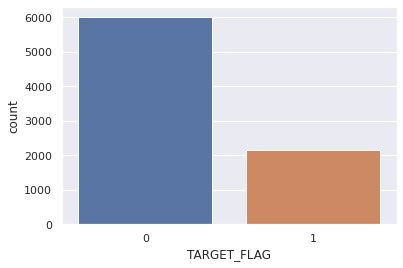

In [17]:
sns.countplot(data_train_nona[target])

**Commentaires:** En observant la distribution des observations suivant la cible, je constate très clairement un déséquilibre entre nos 2 classes. Dans l'échantillon de *Train*, les observations labelisées **0** représentent les 3/4 des observations totales.

#### 2-1-2 Histogrammes et distributions des variables quantitatives

- Séparation des variables quantitatives et qualitatives

In [18]:
def histogramme(data, feature, target):
    plt.figure(7,figsize=(25,20))
    for i in range(len(feature)):
        plt.subplot(7, 4, i + 1)
        plt.gcf().subplots_adjust(wspace = 0.5, hspace = 0.5)
        sns.distplot(data[str(feature[i])][data[target] == 0], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'target = 0'})
        sns.distplot(data[str(feature[i])][data[target] == 1], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'target= 1'})
        plt.grid()
        plt.xlabel('Valeurs des '+str(feature[i]))
        plt.ylabel('Fréquence')
        #plt.title('Histogramme de distribution des '+str(feature[i])+' par label')

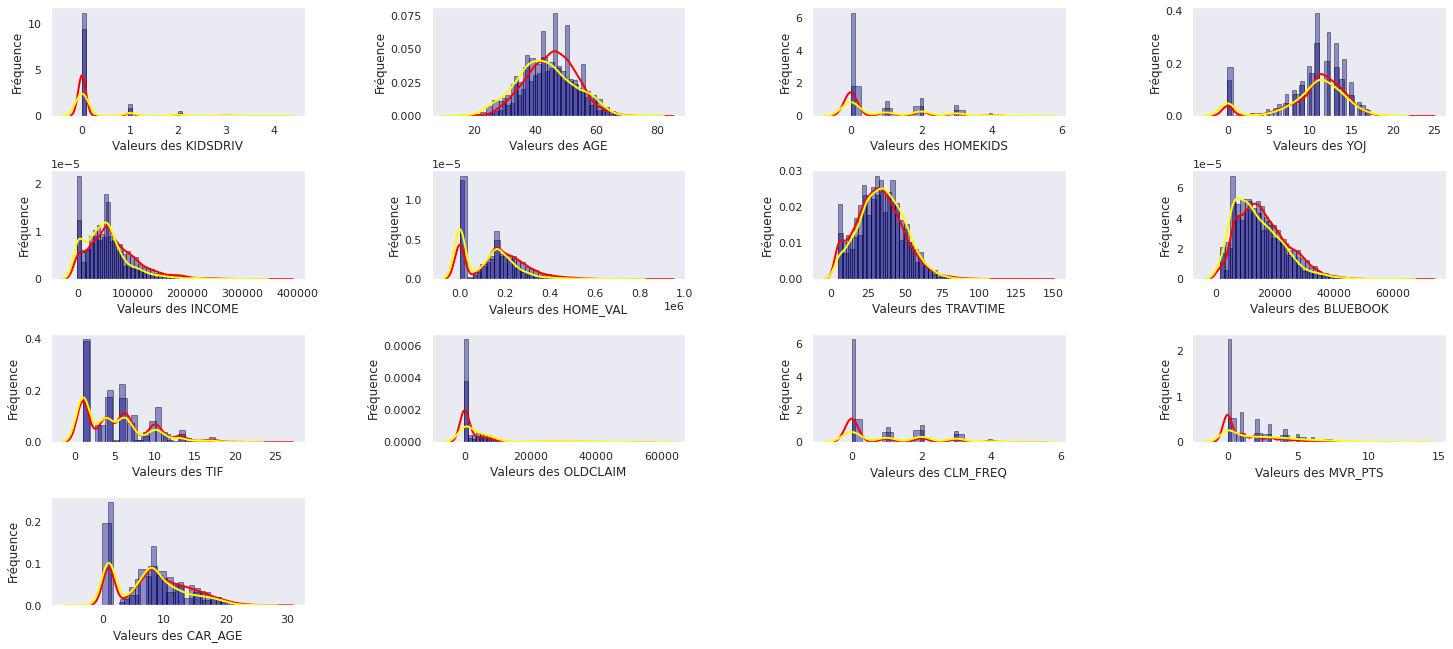

In [19]:
histogramme(data_train_nona, features_numeric, target)

**Commentaires:** En observant ces distributions, je constate qu'aucune variable explicative ne permet de discriminer de façon claire notre cible. Les données à classifier ne sont donc pas linéairement séparables. Ainsi, dans la partie Machine Learning, j'utiliserai des modèles adaptés à ce type de données. 

Je constate également que les variables sont distribuées sur des échelles différentes, il faudra donc centrer et mettre à l'echelle les variables quantitatives.

#### 2-1-3 Boxplot des variables quantitatives

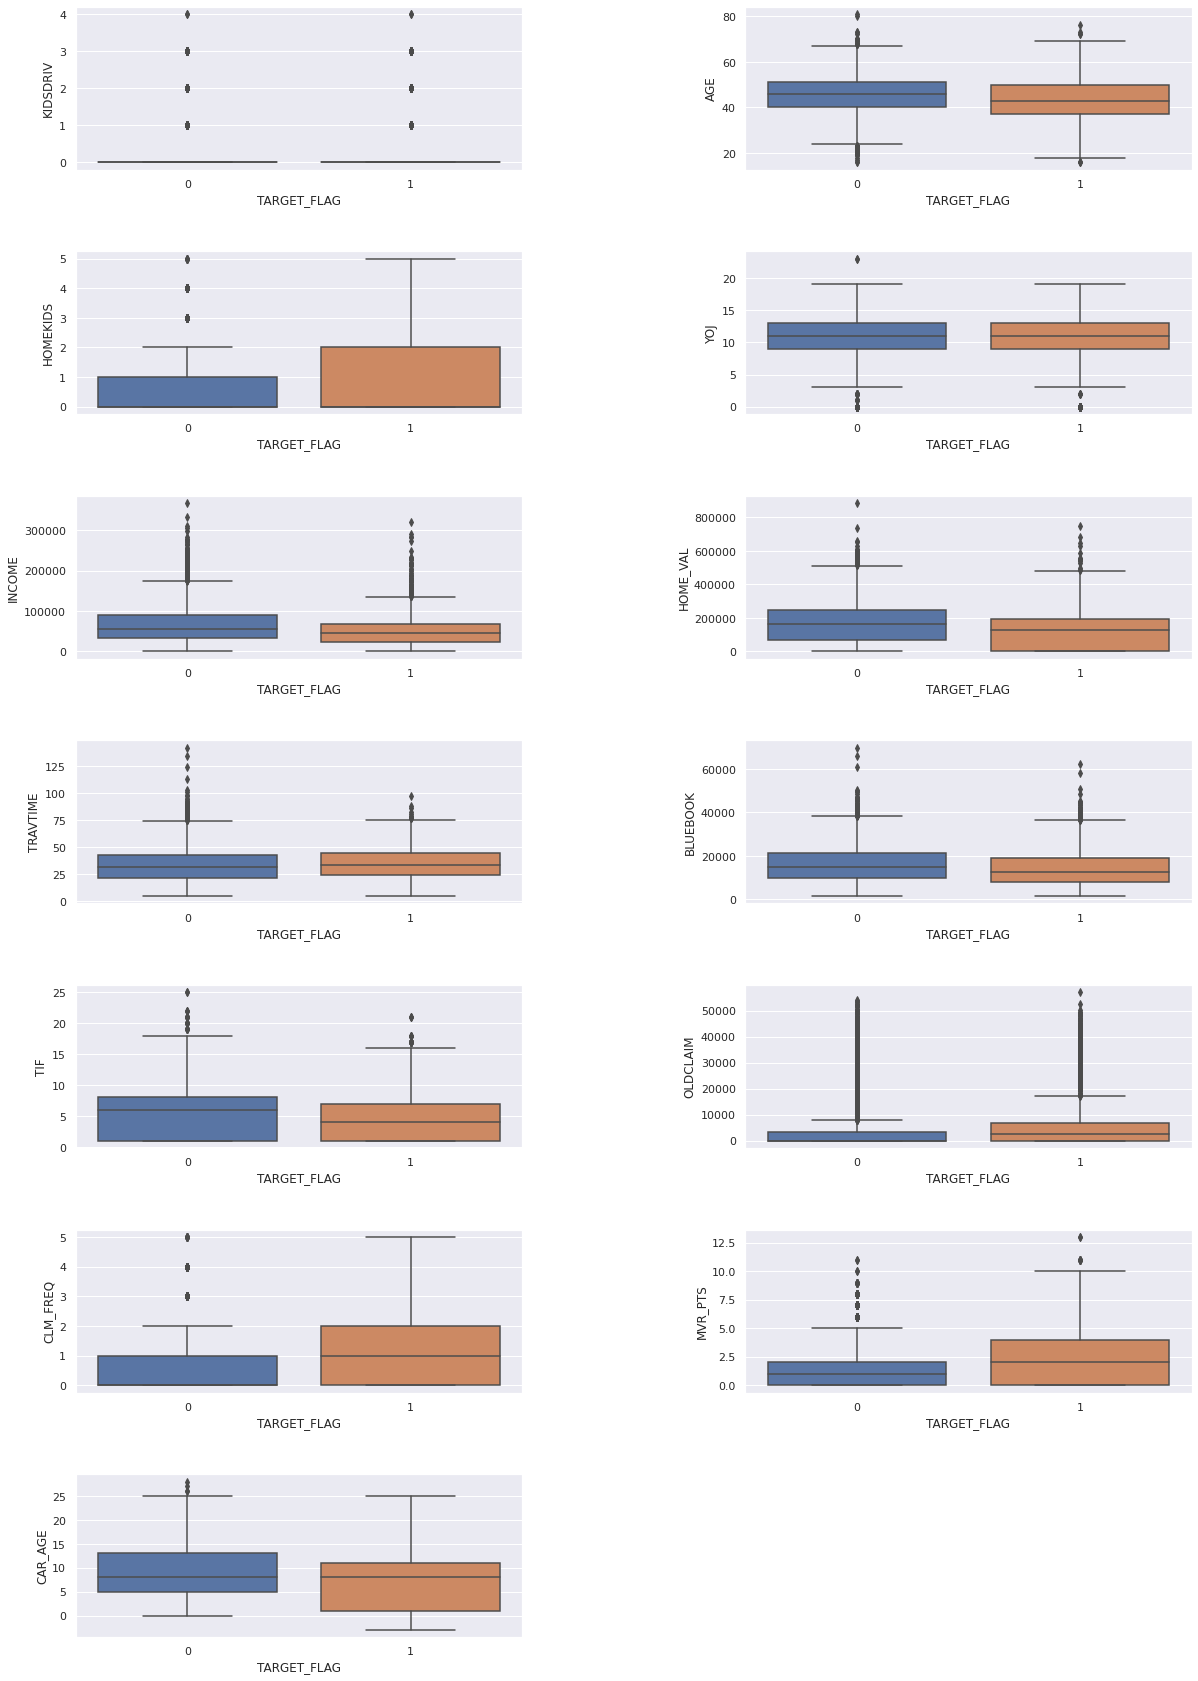

In [20]:
plt.figure(7,figsize=(20,30))
for i in range(len(features_numeric)):
    plt.subplot(7, 2, i + 1)
    plt.gcf().subplots_adjust(wspace = 0.5, hspace = 0.5)
    ax = sns.boxplot(x=target, y=features_numeric[i], data=data_train_nona)

**Commentaires:** En observant ces boxplots, je constate que presque toutes les variables explicatives présentent des "outliers" (valeurs aberrantes).
Ces valeurs souvent qualifiées d'aberrantes sont la plupart du temps des valeurs atypiques permettant de mieux discriminer notre cible. Ne pouvant à cette phase, échanger avec des experts 
sur ces valeurs et ne souhaitant pas les supprimer ou les remplacer par la moyenne ou la médiane qui pourraient fausser notre modélisation par la suite, j'ai fait le choix de les conserver.

### 2-2 Matrice de corrélation

- Matrice de corrélation 

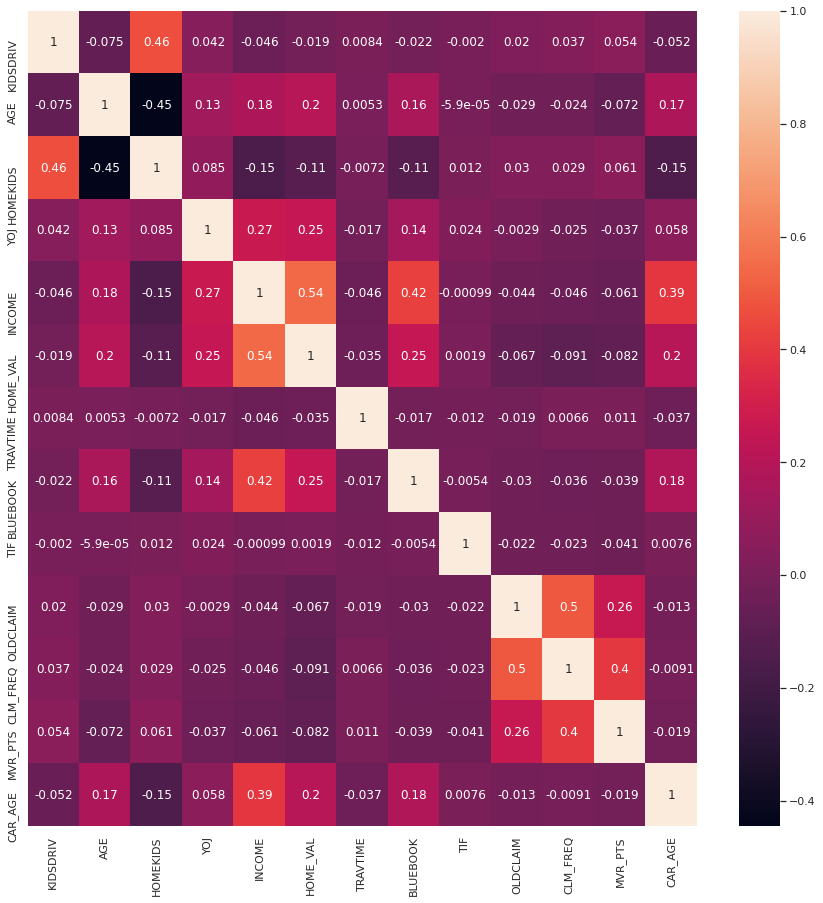

In [21]:
correlations = data_train_nona[features_numeric].corr()
f, ax = plt.subplots(figsize = (15, 15))
sns.heatmap(correlations, annot = True)

**Commentaires** En Analysant cette matrice de corrélation, je ne constate aucune corrélation très forte entre les variables explicatives. je remarque néanmoins une  corrélation de **54%** entre les variables **HOME_VAL** et **INCOME**. 

Si j'avais eu de fortes corrélations (**supérieures à 70%**) entre certaines variables, l'une des trois méthodes ci-dessous aurait été utilisée pour les décorréler:
* La suppression d'une des deux variables fortement corrélées
* La combinaison des deux variables corrélées pour n'en créer qu'une seule
* L'augmentation de notre échantillon de données

## 3- Preprocessing et Feature engineering

**Objectif :** Pour la partie Feature Engineering, j'ai opté pour un encodage simple avec LabelEncoder pour les variables qualitatives. J'aurais pu utiliser le *One Hot Enconding* mais cela aurait eu pour conséquence d'augmenter mon nombre de colonnes.
Par la suite, j'effectuerai une standardisation de mes données.

In [22]:
def engineering_feature(data):
    le = LabelEncoder()
    data[features_categorical] = data[features_categorical].apply(lambda col: le.fit_transform(col))
    
    scaler = StandardScaler()
    
    features = scaler.fit_transform(data.values)
    data_transform = pd.DataFrame(features, columns = data.columns.tolist())
    return data_transform

## 4- Machine learning

### 4-1 Choix des Algorithmes et de la métrique

- **Choix des Algorithmes**

Face au faible nombre d'observations et du fait que celles-ci ne soient pas linéairement séparables, j'ai opté pour des modèles ensemblistes et boostés tels que le **Random Forest** et le **Gradient boosting**.

- **Choix de la métrique**

Concernant les métriques, j'ai plusieurs indicateurs possibles: La précision, le recall, le 'f1-score' et l'accuracy. 
La question à se poser est: Des **Faux Positifs** et **Faux Négatifs**, quels sont ceux qui engendrent les coûts les plus élevés?, autrement dit:
* Est-ce plus coûteux de prédire un TARGET_FLAG à 1 alors que c'est 0? --> Si **Oui**, alors la métrique appropriée est la **précision**

* Ou est-ce plus coûteux de prédire un TARGET_FLAG à 0 alors que c'est 1? --> Si **Oui**, alors la métrique appropriée est le **recall**

* Si un compromis doit-être fait entre les **Faux Positifs** et les **Faux Négatifs** alors la métrique appropriée est le **f1-score**

Cette étape est cruciale pour l'évaluation de la qualité de mon modèle et doit être en général déterminée avec les équipes *Métiers*. Dans ce cadre précis, je suppose que l'objectif est de maximiser l'acquisition des clients donc j'ai décidé de choisir le **recall** comme métrique.

### 4-2 Random Forest

In [23]:
def tuning_params_rdf(data_x, data_y):
    
    ## Définition de l'algorithme Random Forest
    rdf = RandomForestClassifier()
    
    ## Encoding des variables catégorielles et standardisation
    data_x_transform = engineering_feature(data_x)
    
    ## Split du jeu de données Train en 2 jeux de données Train et Test
    X_train, X_test, y_train, y_test = train_test_split(data_x_transform, data_y, test_size=0.2, random_state=42)
    
    ## Définition de la métrique à optimiser
    scorer = make_scorer(recall_score, pos_label=1)
    
    ## grilles des hyperparamètres
    param_grid = {
          'max_depth': [6, 10, 15, 20, 50],
          'criterion': ['gini', 'entropy'],
          'n_estimators': [10, 100,500,1000],
          'max_features': ['auto', 'sqrt', 'log2']}

    
    ## RandomizedSearchCV
    rs_rdf = RandomizedSearchCV(rdf, param_grid, n_iter=20, cv=4, n_jobs=-2,
                            scoring= scorer, refit=False, random_state=42)
    rs_rdf.fit(X_train, y_train)

    resultDf = pd.DataFrame.from_dict(rs_rdf.best_params_,orient='index').T
    convert_dict = {'max_depth': int, 'criterion':object, 'n_estimators':int, 'max_features':object} 

    resultDf = resultDf.astype(convert_dict) 
    
    ## Affinage de la grille autour des meilleurs paramètres RandomizedSearchCV
    param_grid_best = {
          'max_depth': [resultDf.loc[0,'max_depth']-1, resultDf.loc[0,'max_depth'], resultDf.loc[0,'max_depth']+1],
          'criterion': [resultDf.loc[0,'criterion']],
          'n_estimators': [resultDf.loc[0,'n_estimators']-1, resultDf.loc[0,'n_estimators'], resultDf.loc[0,'n_estimators']+1],
          'max_features': [resultDf.loc[0,'max_features']]}
    
    ## GridSearchCV sur la grille affinée
    rs_rdf_grid = GridSearchCV(rdf, param_grid_best, cv=4, n_jobs=-2, scoring= scorer, refit=False)
    rs_rdf_grid.fit(X_train, y_train)
    
    ## Sauvegarde des meilleurs paramètres en dataframe
    resultDf_grid = pd.DataFrame.from_dict(rs_rdf_grid.best_params_, orient='index').T
    resultDf_grid = resultDf_grid.astype(convert_dict) 
    
    
    return resultDf_grid, X_train, X_test, y_train, y_test


In [24]:
def rdf_class_model(X_train, y_train, X_test, y_test, params):
    model_rdf = RandomForestClassifier(criterion=params.loc[0,'criterion'], max_depth=params.loc[0,'max_depth'],
                                 n_estimators=params.loc[0,'n_estimators'], max_features=params.loc[0,'max_features'])

    model_rdf.fit(X_train, y_train)
    
    y_pred = model_rdf.predict(X_test)
    
    score = accuracy_score(y_test, y_pred)
    
    precision = precision_score(y_test, y_pred, pos_label=1)
    
    recall = recall_score(y_test, y_pred, pos_label=1)
    
    score_f1 = f1_score(y_test, y_pred)
    
    return score, precision, recall, score_f1, model_rdf, y_test, y_pred

In [25]:
def model_classification_rdf(data_x, data_y):
    convert_dict = {'max_depth': int, 'criterion':object, 'n_estimators':int, 'max_features':object} 

    parameters = pd.DataFrame(columns=['max_depth','criterion', 'n_estimators','max_features' ])
    parameters = parameters.astype(convert_dict) 
    
    recap = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1_score'])

    print("Etape 1: Tuning des paramètres")
    params, X_train, X_test, y_train, y_test = tuning_params_rdf(data_x, data_y)
    print("\n")

    print("Etape 2: Apprentissage du modèle")
    score, precision, recall, score_f1, model, y_true, y_pred = rdf_class_model(X_train, y_train, X_test, y_test,params)
    print("\n")
    
    print("Fin Apprentissage du modèle")
    recap.loc[0,'accuracy'] = score
    recap.loc[0,'precision'] = precision
    recap.loc[0,'recall'] = recall
    recap.loc[0,'f1_score'] = score_f1
    print("\n")
    
    print("Etape 3: Sauvegarde du modèle")
    #filename = "./model_rdf.sav"
    #pickle.dump(model, open(filename, 'wb'))
    parameters = pd.concat([parameters, params])

    return parameters, recap, model, y_true, y_pred

In [26]:
parameters_rdf, recap_rdf, model_rdf, y_true_rdf, y_pred_rdf = model_classification_rdf(data_train_nona[data_train_nona.columns[data_train_nona.columns!='TARGET_FLAG'].tolist()], data_train_nona['TARGET_FLAG'])

Etape 1: Tuning des paramètres


Etape 2: Apprentissage du modèle


Fin Apprentissage du modèle


Etape 3: Sauvegarde du modèle


In [27]:
recap_rdf

,accuracy,precision,recall,f1_score
0,0.791182,0.728889,0.369369,0.490284


In [28]:
parameters_rdf

,max_depth,criterion,n_estimators,max_features
0,50,gini,1001,sqrt


### 4-3 GradientBoostingClassifier

In [29]:
def tuning_params_gdb(data_x, data_y):
    
     ## Définition de l'algorithme GradientBoostingClassifier
    gdb = GradientBoostingClassifier(verbose=True)
    
    ## Encoding des variables catégorielles et standardisation
    data_x_transform = engineering_feature(data_x)
    
    ## Split du jeu de données Train en 2 jeux de données Train et Test
    X_train, X_test, y_train, y_test = train_test_split(data_x_transform, data_y, test_size=0.2, random_state=42)
    
    ## Définition de la métrique à optimiser
    scorer = make_scorer(recall_score, pos_label=1)
    
    ## grilles des hyperparamètres
    param_grid = {
          'max_depth': [6, 10, 15, 20],
          'learning_rate': [0.001,0.005, 0.01, 0.04, 0.1, 0.2, 0.3, 0.6,1.0],
          'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'n_estimators': [10,100,500,1000]}
    
    ## RandomizedSearchCV
    rs_clf = RandomizedSearchCV(gdb, param_grid, n_iter=20, cv=4, n_jobs=-2,scoring= scorer, refit=False, random_state=42)
    
    rs_clf.fit(X_train, y_train)

    resultDf = pd.DataFrame.from_dict(rs_clf.best_params_, orient='index').T

    convert_dict = {'learning_rate':float, 'max_depth':int,  'n_estimators':int, 'subsample':float} 

    resultDf = resultDf.astype(convert_dict) 
    
    ## Affinage de la grille autour des meilleurs paramètres RandomizedSearchCV
    param_grid_best = {
          'max_depth': [resultDf.loc[0,'max_depth']-1, resultDf.loc[0,'max_depth'], resultDf.loc[0,'max_depth']+1],
          'learning_rate': [resultDf.loc[0,'learning_rate']-0.01, resultDf.loc[0,'learning_rate'], resultDf.loc[0,'learning_rate']+0.01],
          'subsample': [resultDf.loc[0,'subsample']-0.1, resultDf.loc[0,'subsample'], resultDf.loc[0,'subsample']+0.1],
          'n_estimators': [resultDf.loc[0,'n_estimators']-1, resultDf.loc[0,'n_estimators'], resultDf.loc[0,'n_estimators']+1]}
    
    ## GridSearchCV sur la grille affinée
    rs_clf_grid = GridSearchCV(gdb,  param_grid_best, cv=4, n_jobs=-2, scoring= scorer, refit=False)
    
    rs_clf_grid.fit(X_train, y_train)
    
    ## Sauvegarde des meilleurs paramètres en dataframe
    resultDf_grid = pd.DataFrame.from_dict(rs_clf_grid.best_params_, orient='index').T
    resultDf_grid = resultDf_grid.astype(convert_dict) 
    
    return resultDf_grid, X_train, X_test, y_train, y_test

In [30]:
def gdboost_class_model(X_train, y_train, X_test, y_test, params):
    model_clf = GradientBoostingClassifier(learning_rate=params.loc[0,'learning_rate'], max_depth=params.loc[0,'max_depth'], n_estimators=params.loc[0,'n_estimators'],subsample=params.loc[0,'subsample'], verbose=True)
    
    model_clf.fit(X_train, y_train)
    
    y_pred = model_clf.predict(X_test)
    
    score = accuracy_score(y_test, y_pred)
    
    precision = precision_score(y_test, y_pred, pos_label=1)
    
    recall = recall_score(y_test, y_pred, pos_label=1)
    
    score_f1 = f1_score(y_test, y_pred)
    
    return score, precision, recall, score_f1, model_clf, y_test, y_pred

In [31]:
def model_classification_gdb(data_x, data_y):
    
    convert_dict = {'learning_rate':float, 'max_depth':int, 'n_estimators':int, 'subsample':float} 

    parameters = pd.DataFrame(columns=['learning_rate', 'max_depth', 'n_estimators', 'subsample'])
    
    parameters = parameters.astype(convert_dict) 
    recap = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1_score'])

    print("Etape 1: Tuning des paramètres")
    params, X_train, X_test, y_train, y_test = tuning_params_gdb(data_x, data_y)


    print("Etape 2: Apprentissage du modèle")
    score, precision, recall, score_f1, model, y_true, y_pred = gdboost_class_model(X_train, y_train, X_test, y_test,params)

    print("Fin Apprentissage du modèle")
    recap.loc[0,'accuracy'] = score
    recap.loc[0,'precision'] = precision
    recap.loc[0,'recall'] = recall
    recap.loc[0,'f1_score'] = score_f1

    print("Etape 3: Sauvegarde du modèle")
    print("\n")
    #filename = "./model_gdboost.sav"
    #pickle.dump(model, open(filename, 'wb'))
    parameters = pd.concat([parameters, params])

    return parameters, recap, model, y_true, y_pred

In [32]:
parameters_gdb, recap_gdb, model_gdb,  y_true_gdb, y_pred_gdb = model_classification_gdb(data_train_nona[data_train_nona.columns[data_train_nona.columns!='TARGET_FLAG'].tolist()], data_train_nona['TARGET_FLAG'])

Etape 1: Tuning des paramètres
Etape 2: Apprentissage du modèle
      Iter       Train Loss   Remaining Time 
         1           0.9829            1.96s
         2           0.9123            1.88s
         3           0.8630            1.82s
         4           0.8263            1.80s
         5           0.8009            1.79s
         6           0.7770            1.91s
         7           0.7567            1.87s
         8           0.7364            1.84s
         9           0.7168            1.81s
        10           0.6998            1.78s
        20           0.5916            1.52s
        30           0.4896            1.31s
        40           0.4155            1.11s
        50           0.3569            0.92s
        60           0.2998            0.74s
        70           0.2576            0.55s
        80           0.2277            0.36s
        90           0.1875            0.17s
Fin Apprentissage du modèle
Etape 3: Sauvegarde du modèle




In [33]:
recap_gdb

,accuracy,precision,recall,f1_score
0,0.755664,0.565217,0.439189,0.494297


In [34]:
parameters_gdb

,learning_rate,max_depth,n_estimators,subsample
0,0.6,5,99,1.0


**Analyse des résultats :** 
Pour les hyper-paramètres considérés plus haut, j'obtiens respectivement des 'recall'  de **37%** et **44%** pour les modèles **Random Forest** et **Gradient Boosting**. Le modèle Gradient Boosting me donne des performances légèrement meilleures que le Random Forest.

## 5 - Courbe ROC et matrice de confusion de notre meilleur modèle (Gradient Boosting)

### 5-1 Courbe ROC

In [35]:
data_train_nona_transform = engineering_feature(data_train_nona[data_train_nona.columns[data_train_nona.columns!='TARGET_FLAG'].tolist()])

In [36]:
data_train_nona_transform.head()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,-0.334421,1.763651,-0.646120,0.118856,0.127029,-0.389914,-1.237843,1.223932,-1.074976,0.629392,...,-0.175776,1.362319,-1.287232,1.559447,0.048302,1.037176,-0.373691,0.607596,1.755847,-0.507036
1,-0.334421,-0.207617,-0.646120,0.118856,0.647671,-0.389914,0.813614,1.223932,-1.074976,1.321544,...,-0.091445,-1.049422,-1.287232,1.559447,-0.459982,-0.689370,-0.373691,-0.789715,-1.323889,-0.507036
2,-0.334421,-1.135273,0.249732,-0.132500,-0.981442,-0.389914,-0.247481,-0.817039,0.930253,1.321544,...,-1.389666,-0.325900,1.256991,-0.641253,3.948331,1.037176,-0.373691,0.607596,0.306560,-0.507036
3,-0.334421,0.720039,-0.646120,0.872926,-0.160750,-0.389914,1.204357,-0.817039,-1.074976,-1.447066,...,-0.032058,0.397623,-1.287232,1.559447,-0.459982,-0.689370,-0.373691,-0.789715,-0.418084,-0.507036
4,-0.334421,0.604082,-0.646120,0.118856,1.156150,-0.389914,0.707338,-0.817039,0.930253,0.629392,...,0.272009,-1.049422,1.256991,-0.641253,1.729590,1.037176,2.676004,0.607596,1.574686,-0.507036


In [37]:
X_train, X_test, y_train, y_test = train_test_split(data_train_nona_transform, data_train_nona['TARGET_FLAG'], test_size=0.2, random_state=42)

In [38]:
X_test.shape

(1633, 23)

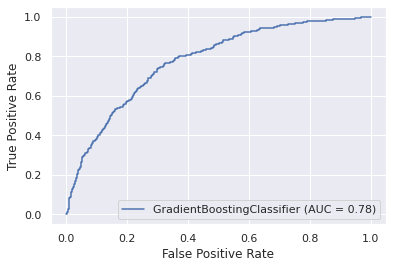

In [39]:
plot_roc_curve(model_gdb, X_test, y_test)

**Commentaires :** La courbe ROC de mon meilleur modèle donne un AUC de **78%**

#### 5-2 Matrice de confusion

In [40]:
def confusion_matrice(y_true, y_pred):
    df_confusion = pd.DataFrame(confusion_matrix(y_true, y_pred), columns=["Target 0", "Target 1"], index=["Target 0", "Target 1"])
    plt.figure(figsize=(10,5))
    sns.set() # for label size
    sns.heatmap(df_confusion, annot=True, fmt="d")
    plt.title('Matrice de confusion')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

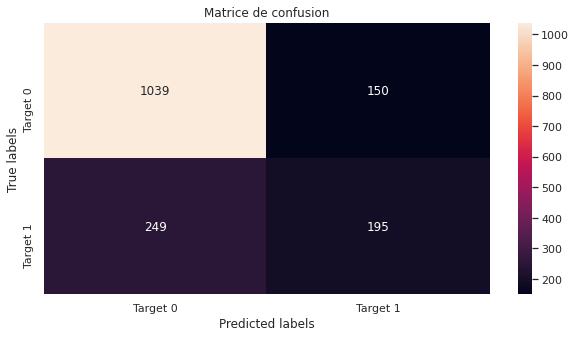

In [41]:
confusion_matrice(y_true_gdb, y_pred_gdb)

**Commentaires :** Les résultats de la matrice de confusion ci-dessus montrent que j'ai **383 observations** sur les **1633** observations du *jeu test* qui sont mal prédites par notre modèle.

## 6 - Interprétation du meilleur modèle avec SHAP (SHapley Additive exPlanations)

Afin d'avoir une meilleure compréhension des variables influentes de mon meilleur modèle, j'ai utilisé le module **SHAP**.

Ce module est basé sur une approche proposée par Lundberg et al., utilisant la valeur de Shapley Additive exPlanation, qui se base sur la théorie des jeux. 
Entre autre, les valeurs de SHAP permet de :
* Expliquer les prédictions d'un modèle,
* Etudier les importances globales et locales des variables,
* Etudier les interactions des variables.

### 6-1 Importance moyenne des variables

In [58]:
explainer = shap.TreeExplainer(model_gdb)
shap_values = explainer.shap_values(X_test)

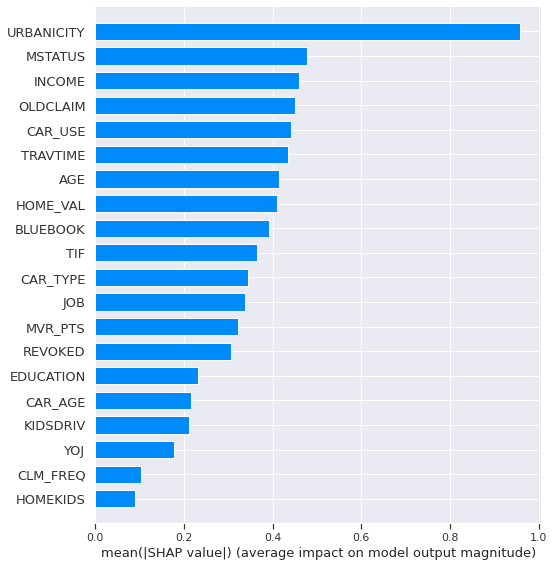

In [59]:
shap.summary_plot(shap_values, X_test, plot_type="bar", class_inds=[1])

Ainsi, en moyenne, la variable **URBANICITY** contribue le plus pour la prédiction effectuée par notre modèle, suivie de **MSTATUS**, **INCOME** et **OLDCLAIM**. **HOMEKIDS** ET **CLM_FREQ** ont le moins d'influence sur la prédiction finale.

### 6-2 Résumé des contributions

les variables présentées dans le graphe ci-dessous sont classées dans l'ordre décroissant (les variables en haut contribuent plus au modèle que les variables inférieures).
* la position sur l'axe horizontal indique si la variable contribue à augmenter la valeur de SHAP(à droite) ou à la diminuer (à gauche) par rapport à la valeur de base
* La couleur indique si la valeur de cette variable est forte (en rouge) ou faible(en bleue)

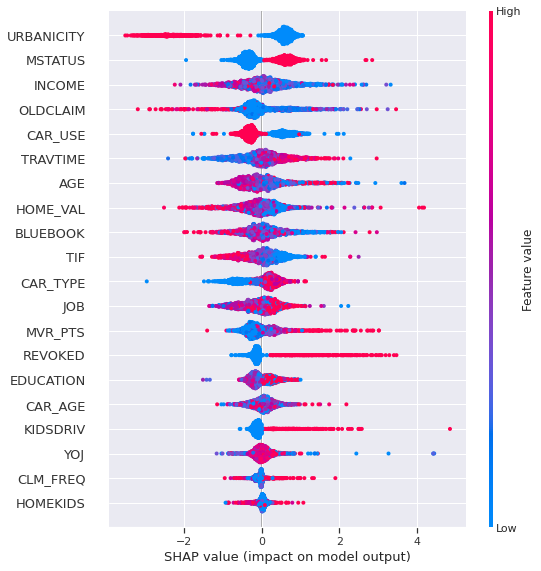

In [44]:
shap.summary_plot(shap_values, X_test)

D'après le graphe ci-dessus, je note pour mon modèle que:
* Lorsque la valeur **URBANICITY** est **z_Highly Rural/ Rural** (en rouge), la valeur de SHAP a tendance à diminuer et contribue fortement à prédire le TARGET_FLAG *0*. Inversement, lorsque la valeur **URBANICITY** est **Highly Urban/ Urban**, la valeur de SHAP augmente et contribue à prédire le TARGET_FLAG *1*
* lorsque le MSTATUT est  **z_No**(rouge), la valeur SHAP augmente et contribue à prédire le TARGET_FLAG *1*. Par contre, un MSTATUT à **yes**(bleu) contribue fortement à prédire le TARGET_FLAG *0*
* Plus la valeur de la variable **CAR_USE** est élevée, plus notre modèle à tendance à prédire le TARGET_FLAG *0*

## 7- Bilan et perspectives

Même si ces premiers résultats sont plutôt satisfaisants, il est important de noter qu'ils peuvent être considérablement améliorés en:
* Echangeant avec des équipes Métiers pour mieux comprendre les variables et la finalité du projet. Cette compréhension est nécessaire pour le choix de la métrique et de la méthode d'imputation des valeurs manquantes.
* Approfondissant la phase de feature engineering: Encoding avec OneHotEncoder, PCA, augmentation des variables et combinaisons de certaines variables, etc.
* Utilisant des méthodes plus performantes pour l'imputation des données (Plus proche voisin, Méthodes d'imputation par chaîne d'équations *MICE* (Bayesian Ridge, KNN iterative, etc.)
* Augmentant l'échantillon de données d'entrainement (train_auto)
* Testant des algorithmes prenant en compte les valeurs manquantes tels que le **xgboost**

## 8- Prédiction sur le jeu de données Test

- Traitement des montants

In [45]:
data_test_process = process_amount(data_test)

- Traitement des valeurs manquantes

In [46]:
data_test_nona = process_nan(data_test_process)

- Encoding des variables catégorielles et standardisation

In [47]:
data_test_transform = engineering_feature(data_test_nona[data_test_nona.columns[data_test_nona.columns!='TARGET_FLAG'].tolist()])

In [48]:
data_test_transform.head()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,-0.333872,0.350097,-0.642668,0.145558,-0.152143,-0.376652,-1.218022,1.23602,-1.097699,-0.769129,...,0.768354,-1.069179,0.764611,1.606321,-0.469694,-0.711358,-0.372599,0.106225,0.327030,-0.481535
1,1.720210,-0.588757,0.253134,0.145558,-0.197407,2.654971,-1.218022,1.23602,-1.097699,1.301330,...,0.409032,0.190236,-1.297143,-0.622541,-0.084916,0.167982,-0.372599,0.106225,-1.283382,-0.481535
2,-0.333872,-0.119330,1.148936,0.390751,-0.357978,2.654971,-1.218022,1.23602,0.910996,1.301330,...,-1.131086,1.197768,1.280050,-0.622541,-0.469694,-0.711358,-0.372599,-0.801670,0.327030,2.076693
3,-0.333872,-1.175541,1.148936,0.145558,-0.846154,2.654971,-1.218022,1.23602,-1.097699,1.301330,...,-0.737487,0.190236,-0.266266,-0.622541,-0.469694,-0.711358,2.683853,-0.801670,-0.746578,2.076693
4,-0.333872,1.641022,-0.642668,0.390751,0.605448,-0.376652,-1.218022,1.23602,-1.097699,1.301330,...,-0.005842,-1.069179,-1.297143,1.606321,4.768542,1.047323,-0.372599,1.014120,-1.283382,-0.481535


- Prédiction sur le jeu de données test_auto

In [49]:
data_test_pred = model_gdb.predict(data_test_transform)

In [50]:
data_test_pred.shape

(2141,)

In [51]:
data_test_transform['TARGET_FLAG_PREDICT'] = data_test_pred

In [52]:
data_test_transform.head()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,...,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY,TARGET_FLAG_PREDICT
0,-0.333872,0.350097,-0.642668,0.145558,-0.152143,-0.376652,-1.218022,1.23602,-1.097699,-0.769129,...,-1.069179,0.764611,1.606321,-0.469694,-0.711358,-0.372599,0.106225,0.327030,-0.481535,0
1,1.720210,-0.588757,0.253134,0.145558,-0.197407,2.654971,-1.218022,1.23602,-1.097699,1.301330,...,0.190236,-1.297143,-0.622541,-0.084916,0.167982,-0.372599,0.106225,-1.283382,-0.481535,0
2,-0.333872,-0.119330,1.148936,0.390751,-0.357978,2.654971,-1.218022,1.23602,0.910996,1.301330,...,1.197768,1.280050,-0.622541,-0.469694,-0.711358,-0.372599,-0.801670,0.327030,2.076693,0
3,-0.333872,-1.175541,1.148936,0.145558,-0.846154,2.654971,-1.218022,1.23602,-1.097699,1.301330,...,0.190236,-0.266266,-0.622541,-0.469694,-0.711358,2.683853,-0.801670,-0.746578,2.076693,0
4,-0.333872,1.641022,-0.642668,0.390751,0.605448,-0.376652,-1.218022,1.23602,-1.097699,1.301330,...,-1.069179,-1.297143,1.606321,4.768542,1.047323,-0.372599,1.014120,-1.283382,-0.481535,0


In [53]:
data_test_transform[data_test_transform['TARGET_FLAG_PREDICT']==1].shape

(437, 24)

- Sauvegarde du fichier en csv

In [54]:
data_test_transform['TARGET_FLAG_PREDICT'].to_csv('./prediction.csv', sep=',')